### IMPORTS Y SETUP DE RUTA

In [ ]:
import pprint
import sys
import os
import json
import mlflow
import joblib
import mlflow.sklearn
from sklearn import set_config
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../")  # Para que Python encuentre todo en ../src

from src.config import config
from src import (
    load_validate,
    target_processing,
    cleaning,
    eda,
    feature_engineering,
    split,
    pipeline,
    experiment
)


### CARGA Y VALIDACIÓN DEL DATASET

In [15]:
# Cargar dataset desde el path definido en el config
df = load_validate.load_dataset(config["path"])

# Valida columnas esperadas
df = load_validate.validate_structure(df, config["expected_columns"])

# Resumen estado inicial
summary = load_validate.quick_explore(df)

# Guarda estado inicial limpio para referencia
load_validate.save_initial_state(df, "data/initial_clean.csv")

# Muestra resumen
pprint.pprint(summary)


[INFO] Dataset cargado correctamente desde adult.csv con shape (32561, 15)
[INFO] Columnas finales en el DataFrame: ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']
[INFO] Resumen rápido del dataset:
 - Shape: (32561, 15)
 - Nulos por columna: {'age': 0, 'workclass': 1836, 'fnlwgt': 0, 'education': 0, 'education.num': 0, 'marital.status': 0, 'occupation': 1843, 'relationship': 0, 'race': 0, 'sex': 0, 'capital.gain': 0, 'capital.loss': 0, 'hours.per.week': 0, 'native.country': 583, 'income': 0}
 - Únicos por columna: {'age': 73, 'workclass': 8, 'fnlwgt': 21648, 'education': 16, 'education.num': 16, 'marital.status': 7, 'occupation': 14, 'relationship': 6, 'race': 5, 'sex': 2, 'capital.gain': 119, 'capital.loss': 92, 'hours.per.week': 94, 'native.country': 41, 'income': 2}
[INFO] Estado inicial del dataset guardado en data/initial_clean.

### INSPECCIÓN, LIMPIEZA Y CODIFICACIÓN DEL TARGET

[INFO] Valores únicos y frecuencias en 'income': {'<=50K': 24720, '>50K': 7841}
[INFO] Frecuencias relativas: {'<=50K': 0.7591904425539756, '>50K': 0.2408095574460244}
[INFO] Nulos en target: 0
[INFO] Tipo de datos en target: object
[INFO] Target 'income' normalizado. Valores fuera de ['<=50K', '>50K']: 0
[INFO] Target codificado correctamente ({'<=50K': 0, '>50K': 1})
[INFO] Estado post-limpieza del target 'income':
  - Shape actual: (32561, 15)
  - Valores codificados: {np.int64(0): 24720, np.int64(1): 7841}
  - Filas eliminadas/cambiadas: 0


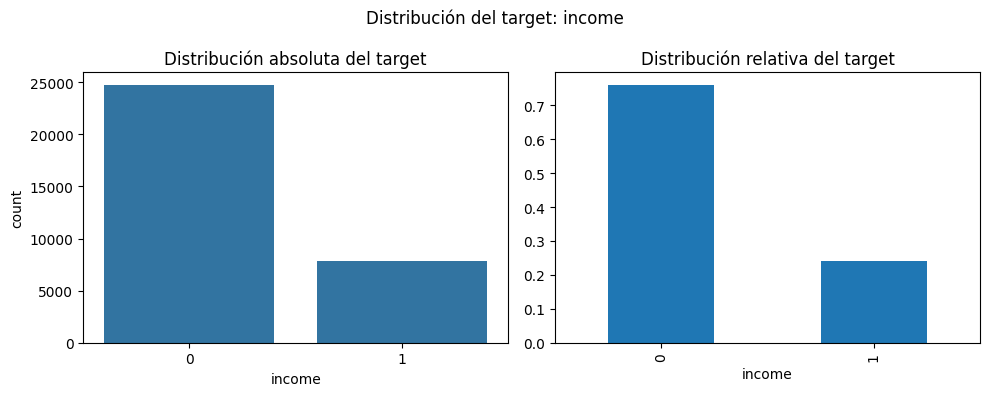

[INFO] Visualización de distribución de clases mostrada.
{'dtype': 'object',
 'n_missing': np.int64(0),
 'relative_frequencies': {'<=50K': 0.7591904425539756,
                          '>50K': 0.2408095574460244},
 'unique_values': {'<=50K': 24720, '>50K': 7841}}


In [16]:
# Inspecciona los valores del target (income) y detecta anomalías
target_summary = target_processing.inspect_target_values(df, config["target"])

# Limpia y normaliza los valores del target (espacios, mayúsculas, valores no válidos)
df = target_processing.clean_normalize_target(df, config["target"])

# Codifica el target para modelado usando el mapping definido en config
df = target_processing.encode_target(df, config["target"], config["target_mapping"])

# Logging del estado post-limpieza
removed_rows = df[config["target"]].isna().sum()
target_processing.log_target_status(df, config["target"], removed_rows)

# Visualiza la distribución de clases (balance de dataset)
target_processing.plot_target_distribution(df, config["target"])

# Si quieres, imprime el resumen para documentar
pprint.pprint(target_summary)


### LIMPIEZA BÁSICA DEL DATASET

In [17]:
# 1. Elimina duplicados completos
df, n_dupes = cleaning.drop_duplicates(df)

# 2. Analiza y reporta valores nulos (incluyendo target)
missing_summary = cleaning.analyze_missing_values(df, config["target"])

# 3. Corrige tipos y formatos evidentes (espacios, mayúsculas/minúsculas)
df = cleaning.fix_column_types_and_formats(df)

# 4. Revisión superficial de outliers groseros (sin modificar aún)
gross_outliers = cleaning.detect_gross_outliers(df, config["num_features"])

# 5. Logging de todo el estado post-limpieza básica
cleaning.log_cleaning_status(df, n_dupes, missing_summary)

# Opcional: imprime resumen de outliers para decisión posterior
pprint.pprint(gross_outliers)


[INFO] Duplicados eliminados: 24 (shape final: (32537, 15))
[INFO] Nulos por columna: {'age': 0, 'workclass': 1836, 'fnlwgt': 0, 'education': 0, 'education.num': 0, 'marital.status': 0, 'occupation': 1843, 'relationship': 0, 'race': 0, 'sex': 0, 'capital.gain': 0, 'capital.loss': 0, 'hours.per.week': 0, 'native.country': 582, 'income': 0}
[INFO] Total nulos en dataset: 4261
[INFO] Nulos en target: 0
[INFO] Tipos y formatos corregidos para columnas relevantes.
[INFO] Columna 'age': min=17, max=90, valores negativos=0
[INFO] Columna 'education.num': min=1, max=16, valores negativos=0
[INFO] Columna 'capital.gain': min=0, max=99999, valores negativos=0
[INFO] Columna 'capital.loss': min=0, max=4356, valores negativos=0
[INFO] Columna 'hours.per.week': min=1, max=99, valores negativos=0
[INFO] Estado tras limpieza básica:
  - Shape actual: (32537, 15)
  - Duplicados eliminados: 24
  - Nulos por columna: {'age': 0, 'workclass': 1836, 'fnlwgt': 0, 'education': 0, 'education.num': 0, 'marital

###

### Análisis Exploratorio

In [21]:
# Estadísticos descriptivos para numéricas
num_desc = eda.describe_numerical(df, config["num_features"])

# Estadísticos para categóricas (cardinalidad, más frecuente, top 5)
cat_desc = eda.describe_categorical(df, config["cat_features"])

[INFO] Estadísticos descriptivos (numéricas):
                  count         mean          std   min   25%   50%   75%  \
age             32537.0    38.585549    13.637984  17.0  28.0  37.0  48.0   
education.num   32537.0    10.081815     2.571633   1.0   9.0  10.0  12.0   
capital.gain    32537.0  1078.443741  7387.957424   0.0   0.0   0.0   0.0   
capital.loss    32537.0    87.368227   403.101833   0.0   0.0   0.0   0.0   
hours.per.week  32537.0    40.440329    12.346889   1.0  40.0  40.0  45.0   

                    max  
age                90.0  
education.num      16.0  
capital.gain    99999.0  
capital.loss     4356.0  
hours.per.week     99.0  
[INFO] Estadísticos descriptivos (categóricas):
              col  n_unique           most_freq  freq_most_freq  \
0       workclass         9             Private           22673   
1  marital.status         7  Married-civ-spouse           14970   
2      occupation        15      Prof-specialty            4136   
3    relationship  

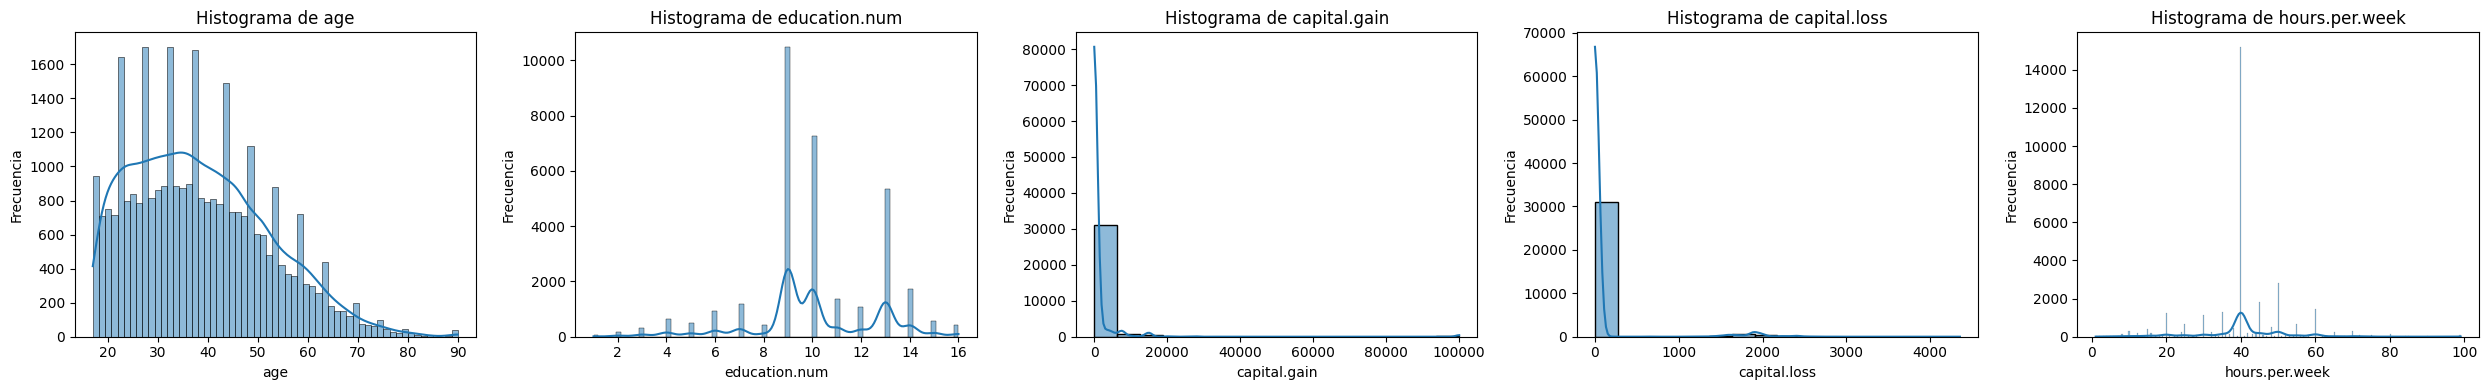

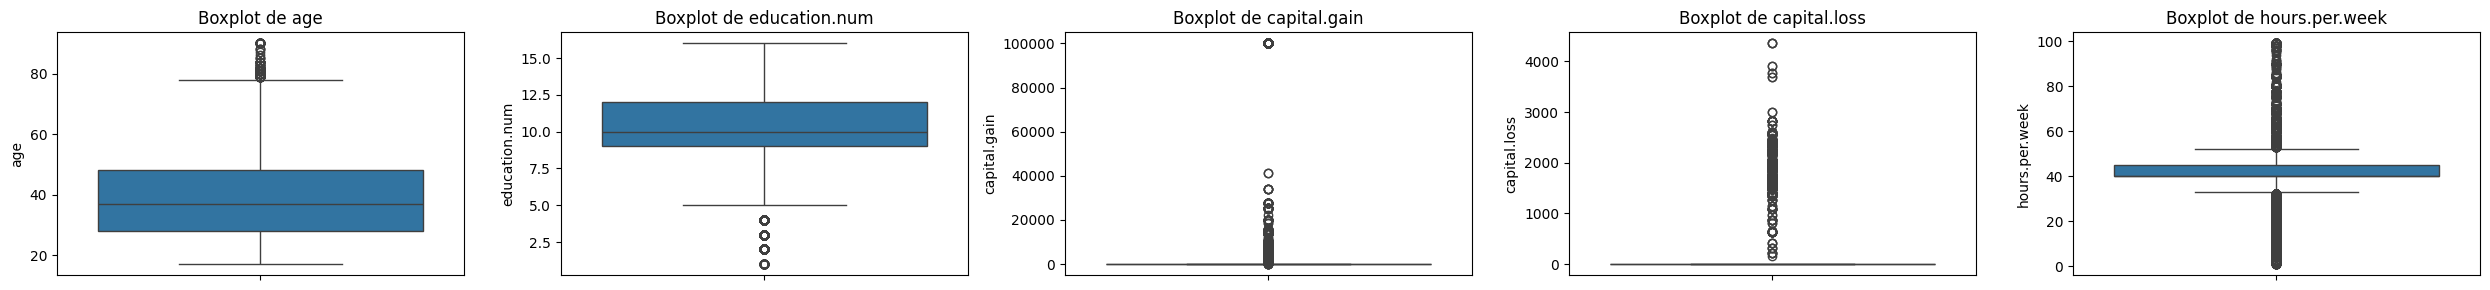

In [19]:
# Distribuciones de variables numéricas (histogramas + boxplots)
eda.plot_numerical_distributions(df, config["num_features"])

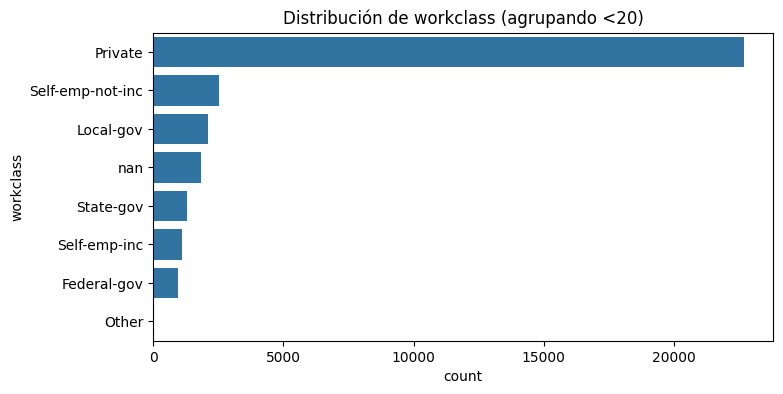

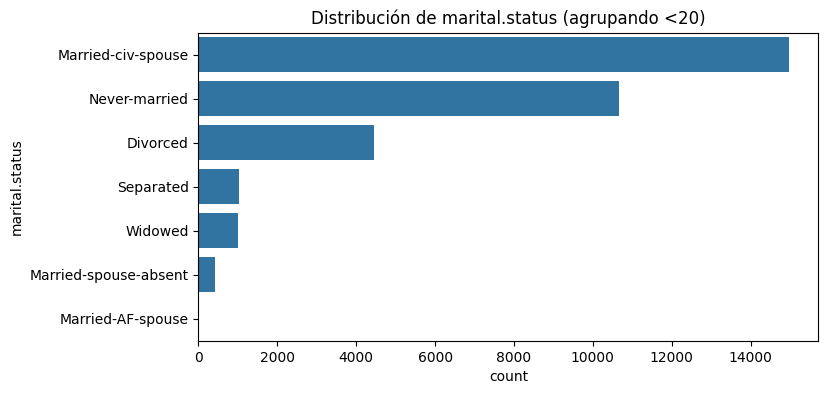

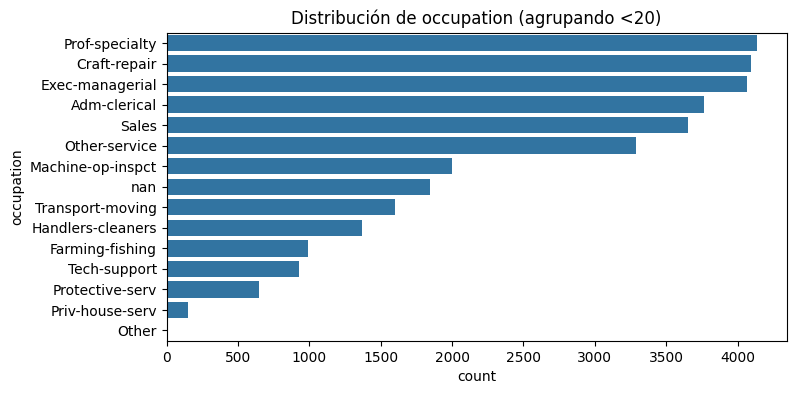

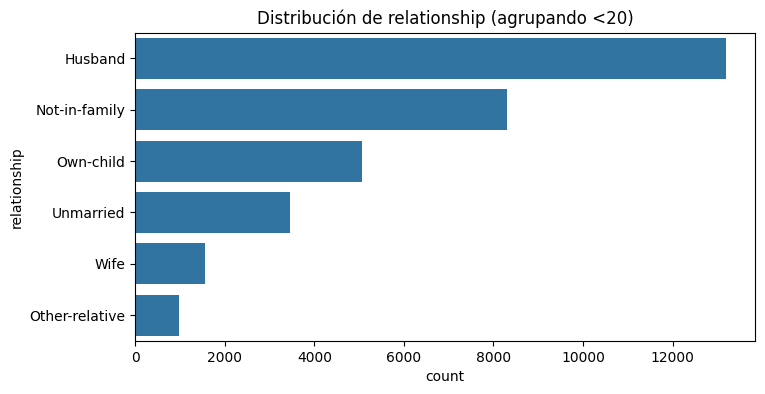

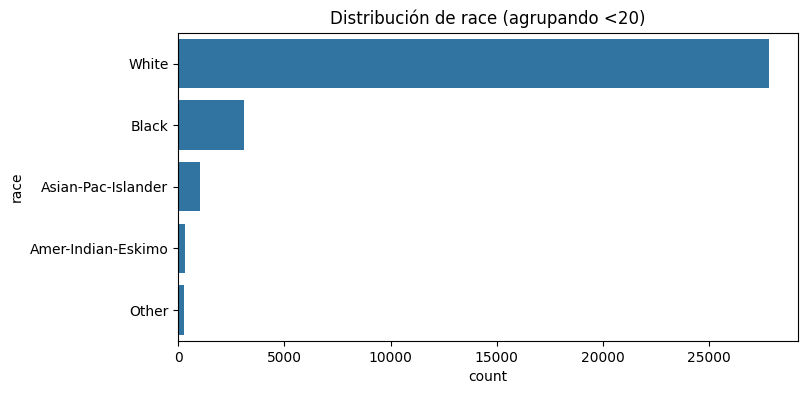

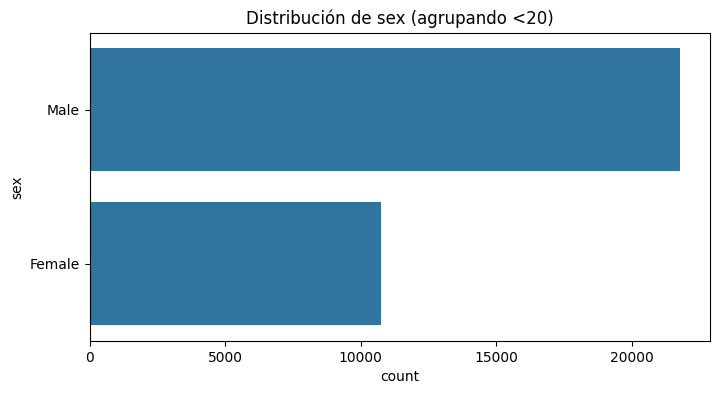

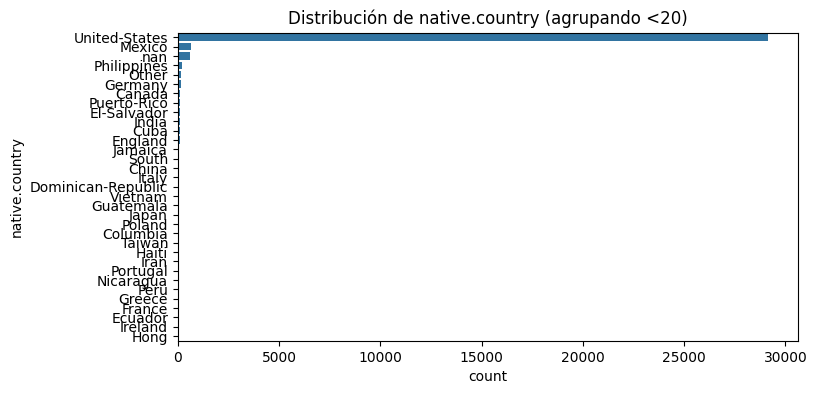

In [20]:
# Distribuciones de variables categóricas (conteo, agrupando bajas frecuencias)
eda.plot_categorical_distributions(df, config["cat_features"], min_freq=20)

In [ ]:

# Relación univariada de cada feature con el target
eda.plot_feature_target_relationship(df, config["features"], config["target"])

# Correlación entre variables numéricas
corr_matrix = eda.correlation_analysis(df, config["num_features"])

# Detecta pares de features muy correlacionados (posibles redundancias)
redundant_pairs = eda.analyze_feature_redundancy(df, config["num_features"])

## Mini-Informe EDA

1. Variables Numéricas

Variables: age, education.num, capital.gain, capital.loss, hours.per.week

Distribución:

age: [17, 90], media ≈ 39, sesgada hacia adultos jóvenes, con outliers de 70+ años.

education.num: [1, 16], completa, mayoría entre 9-13 (HS-grad/college).

capital.gain/loss: Extremadamente sesgadas, la mayoría son 0, con spikes .

→ Winsorización o log-transform (?), puede perder significado.

hours.per.week: [1, 99], mayoría entre 35-45 (full-time), OL abajo de 10 y arriba de 70.

2. Variables Categóricas
Variables: workclass, marital.status, occupation, relationship, race, sex, native.country

Cardinalidad:

workclass: 8  (~1800 nulos)

occupation: 14  (~1800 nulos)

marital.status: 7 

relationship: 6 

race: 5 (mayoría "White")

sex: 2 ("Male" ≈ 2/3)

native.country: 41 (29/32 "United-States" -resto subrepresentado)

Observaciones:

Poco frecuentes en native.country, occupation y algunas en workclass.

Valores nulos concentrados en workclass, occupation, y native.country.

Agrupar raras en "Other" -evitar columnas dummies poco informativas.

3. Nulos
Total nulos: 4261 (excepto target)

workclass: 1836 nulos

occupation: 1843 nulos

native.country: 582 nulos

Categóricas:

Cardinalidades manejables, salvo native.country.

5. Relación con el Target

age: Los que ganan más de 50K tienden a ser mayores (desplazamiento hacia la derecha).

education.num: A más educación, más chances de >50K.

capital.gain/loss: Los que tienen capital gains/loss relevantes, desproporcionadamente ganan >50K (pocos casos).

hours.per.week: Ligeramente mayor para >50K, con solapamiento.

marital.status, occupation, relationship:

Ciertos valores (ej: "Exec-managerial", "Prof-specialty") fuertemente asociados a >50K.

"Married-civ-spouse" correlaciona fuerte con ingresos altos.

6. Insights inmediatos para Feature Engineering

Imputar nulos en categóricas usando "most_frequent" (moda).

En native.country, agrupar todas menos "United-States" como "Other".

Considerar transformar capital.gain y capital.loss (log, bins, winsorize).

Desbalance de clases: usar métrica  AUC/Recall.

Eliminar duplicidad entre education (string) y education.num si se comprueba que una no aporta extra.

### INGENIERÍA DE FEATURES -GROUPING

In [ ]:
# 1. Análisis y documentación de redundancias e irrelevancias
redundancias = feature_engineering.analyze_feature_redundancy_irrelevance(
    df,
    features_info={
        "redundant": ["education"],  # 'education' por 'education.num'
        "irrelevant": ["fnlwgt"],    # no aporta
    }
)

# 2. Propone y documenta agrupamientos de categorías poco frecuentes
agrupamientos = feature_engineering.propose_category_groupings(
    df,
    config["cat_features"],
    min_freqs={k: v["min_freq"] for k, v in config["grouping"].items()},
    other_label="Other"
)

# 3. Define y documenta listas de features para modelar
features_dict = feature_engineering.prepare_final_features(
    df,
    config["drop_features"],    
    config["target"]          
)

# 4. Detecta issues pipeline (nulos, alta cardinalidad)
issues = feature_engineering.collect_pipeline_issues(df, features_dict)

# 5. Guarda config de features
feature_engineering.save_feature_config(features_dict, "features_config.json")

# 6. Muestra log
print("Redundancias e irrelevancias detectadas:")
pprint.pprint(redundancias)
print("\nAgrupamientos sugeridos:")
pprint.pprint(agrupamientos)
print("\nFeatures finales:")
pprint.pprint(features_dict)
print("\nIssues para pipeline:")
pprint.pprint(issues)


[INFO] Features redundantes: ['education']
[INFO] Features irrelevantes: ['fnlwgt']
[INFO] En 'workclass' se agruparán 8 categorías poco frecuentes como 'Other' (min_freq=3000).
[INFO] En 'marital.status' se agruparán 4 categorías poco frecuentes como 'Other' (min_freq=2000).
[INFO] En 'occupation' se agruparán 8 categorías poco frecuentes como 'Other' (min_freq=2000).
[INFO] En 'relationship' se agruparán 3 categorías poco frecuentes como 'Other' (min_freq=4000).
[INFO] En 'race' se agruparán 2 categorías poco frecuentes como 'Other' (min_freq=500).
[INFO] En 'native.country' se agruparán 41 categorías poco frecuentes como 'Other' (min_freq=1000).
[INFO] Features finales para modelado: {'final_features': ['age', 'workclass', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country'], 'final_num_features': ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week'], 'final_cat_featur

### SPLIT TRAIN/TEST CON CONTROL DE CALIDAD DEL SPLIT

[INFO] Matriz X preparada (shape: (32537, 12)), vector y (shape: (32537,))
[INFO] Split estratificado hecho. X_train: (26029, 12), X_test: (6508, 12)
[INFO] Distribución de clases (train): {np.int64(0): 0.7590764147681432, np.int64(1): 0.24092358523185678}
[INFO] Distribución de clases (test): {np.int64(0): 0.7590657652120467, np.int64(1): 0.24093423478795328}
Distribución y calidad del split:
{'n_test': 6508,
 'n_test_null': np.int64(0),
 'n_train': 26029,
 'n_train_null': np.int64(0),
 'test_dist': {np.int64(0): 0.7590657652120467,
               np.int64(1): 0.24093423478795328},
 'train_dist': {np.int64(0): 0.7590764147681432,
                np.int64(1): 0.24092358523185678}}


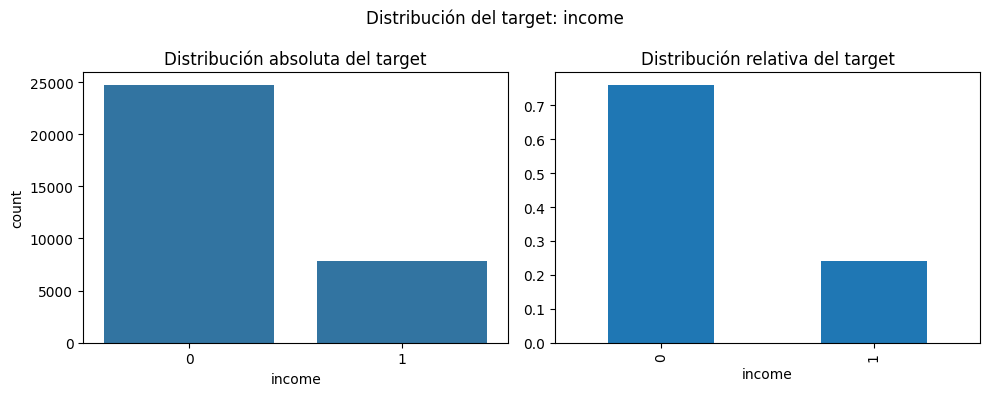

[INFO] Visualización de distribución de clases mostrada.


In [46]:
# 1. Carga features desde archivo (si no está ya cargado)
with open("features_config.json") as f:
    features_dict = json.load(f)

# 2. Prepara X (features) e y (target)
X, y = split.prepare_X_y(df, features_dict, config["target"])

# 3. Split estratificado
splits = split.stratified_train_test_split(
    X, y,
    test_size=config["split"]["test_size"],
    random_state=config["split"]["random_state"]
)

# 4. Chequea calidad del split
split_quality = split.check_split_quality(splits["y_train"], splits["y_test"])

# 5. Logging y guardado de los splits
# split.log_and_save_split_state(splits, out_dir="splits")

# 6. Mostrar resumen de calidad del split
print("Distribución y calidad del split:")
pprint.pprint(split_quality)

# 7. Plotea dist del target en train y test
target_processing.plot_target_distribution(df, config["target"])


### PIPELINE

In [36]:
# Construye el pipeline completo (preprocesamiento + modelo) según config y features_dict
pipe = pipeline.build_pipeline(config, features_dict)

# Muestra el resumen del pipeline (estructura y pasos)
set_config(display="diagram")  # Activar visualización gráfica para Jupyter

pipe


[INFO] ColumnTransformer construido con 8 transformadores.
[INFO] Pipeline completo construido: RandomForestClassifier


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('outlier',
                                                                   OutlierTransformer()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'education.num',
                                                   'capital.gain',
                                                   'capital.loss',
                                                   'hours.per.week']),
                                                 ('cat_workclass',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex']),
                                                 ('cat_native.country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   CategoryGrouper(col='native.country',
                                                                                   min_freq=1000)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['native.country'])])),
                ('model', RandomForestClassifier(random_state=42))])

### TEST: ENTRENAMIENTO RÁPIDO + TRACKING EN MLFLOW

In [9]:
# 1. Setup de MLflow (tracking URI y nombre de experimento desde config)
experiment.setup_mlflow_experiment(
    config["mlflow"]["tracking_uri"], 
    config["mlflow"]["experiment_name"]
)

# 2. Entrenamiento con autolog y evaluación en test (sin gridsearch)
mlflow.sklearn.autolog()

with mlflow.start_run(run_name="entrenamiento_inicial"):
    # Fit del pipeline en los datos de entrenamiento
    pipe.fit(splits["X_train"], splits["y_train"])
    
    # Evaluación rápida en test
    score = pipe.score(splits["X_test"], splits["y_test"])
    print(f"[INFO] Score en test set: {score:.4f}")

    # Loguear la métrica test manualmente (opcional, por si quieres nombre custom)
    mlflow.log_metric("test_score", score)

    # (Opcional) Guardar el modelo entrenado como artefacto
    
    joblib.dump(pipe, "results_out/model_inicial.joblib")
    mlflow.log_artifact("results_out/model_inicial.joblib")


[INFO] MLflow configurado: file:./mlruns, experimento: Mini_Proyecto_Adult_Income


2025/05/31 17:29:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/javs/anaconda3/envs/mlflow_env/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/05/31 17:30:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/javs/anaconda3/envs/mlflow

[INFO] Score en test set: 0.8328


### GRID SEARCH EXPLORATORIO

In [54]:
## Explorando imputadore y valores de corte para OL

# MLflow
experiment.setup_mlflow_experiment(
    config["mlflow"]["tracking_uri"], 
    config["mlflow"]["experiment_name"]
)

# Construye el pipeline como antes
pipe = pipeline.build_pipeline(config, features_dict)

# Define el param_grid para la búsqueda exploratoria
param_grid = {
    # Imputación numérica
    "preprocessing__num__imputer__strategy": ["median", "mean"],

    # Imputación categórica en cada variable
    "preprocessing__cat_workclass__imputer__strategy": ["most_frequent"],
    "preprocessing__cat_occupation__imputer__strategy": ["most_frequent"],
    "preprocessing__cat_native.country__imputer__strategy": ["most_frequent"],

    # Outlier handling
    "preprocessing__num__outlier__strategy": ["none", "clip"],
    "preprocessing__num__outlier__pmin": [0.01, 0.02],   # percentiles bajos
    "preprocessing__num__outlier__pmax": [0.98, 0.99],   # percentiles altos

    # Hiperparámetros del RandomForest
    "model__n_estimators": [100, 300],
    "model__max_depth": [None, 10, 20],
}

# Corre el experimento con tracking y guardado de resultados
experiment.run_gridsearch_experiment(
    pipeline=pipe,
    param_grid=param_grid,
    X_train=splits["X_train"],
    y_train=splits["y_train"],
    X_test=splits["X_test"],
    y_test=splits["y_test"],
    scoring="accuracy",
    cv=5,
    out_dir="results_out/prepro_imp_ol"
)

[INFO] MLflow configurado: file:./mlruns, experimento: Mini_Proyecto_Adult_Income
[INFO] ColumnTransformer construido con 8 transformadores.
[INFO] Pipeline completo construido: RandomForestClassifier


2025/06/01 15:40:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/javs/anaconda3/envs/mlflow_env/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END model__max_depth=None, model__n_estimators=100, preprocessing__cat_native.country__imputer__strategy=most_frequent, preprocessing__cat_occupation__imputer__strategy=most_frequent, preprocessing__cat_workclass__imputer__strategy=most_frequent, preprocessing__num__imputer__strategy=median, preprocessing__num__outlier__pmax=0.98, preprocessing__num__outlier__pmin=0.01, preprocessing__num__outlier__strategy=clip; total time=   5.3s
[CV] END model__max_depth=None, model__n_estimators=100, preprocessing__cat_native.country__imputer__strategy=most_frequent, preprocessing__cat_occupation__imputer__strategy=most_frequent, preprocessing__cat_workclass__imputer__strategy=most_frequent, preprocessing__num__imputer__strategy=median, preprocessing__num__outlier__pmax=0.98, preprocessing__num__outlier__pmin=0.01, preprocessing__num__outlier__strategy=none; total time=   7.1s
[CV] END model__max_depth=None, model__n_estimators=100,

2025/06/01 15:51:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/javs/anaconda3/envs/mlflow_env/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/01 15:51:54 INFO mlflow.sklearn.utils: Logging the 5 best runs, 91 runs will be omitted.


[INFO] Mejor score (cv): 0.8600022732950933
[INFO] Mejores hiperparámetros: {'model__max_depth': 10, 'model__n_estimators': 300, 'preprocessing__cat_native.country__imputer__strategy': 'most_frequent', 'preprocessing__cat_occupation__imputer__strategy': 'most_frequent', 'preprocessing__cat_workclass__imputer__strategy': 'most_frequent', 'preprocessing__num__imputer__strategy': 'median', 'preprocessing__num__outlier__pmax': 0.98, 'preprocessing__num__outlier__pmin': 0.01, 'preprocessing__num__outlier__strategy': 'none'}
[INFO] Experimento terminado y trackeado en MLflow.


Mejores hiperparámetros: 

    max_depth: 10, 

    n_estimators: 300, 

    native.country__imputer__strategy: 'most_frequent', 

    occupation__imputer__strategy: 'most_frequent', 

    workclass__imputer__strategy: 'most_frequent', 

    num__imputer__strategy: 'median', 

    num__outlier__pmax: 0.98, 

    num__outlier__pmin: 0.01, 

    num__outlier__strategy: 'none'


##### VISUALIZACIÓN DE RESULTADOS

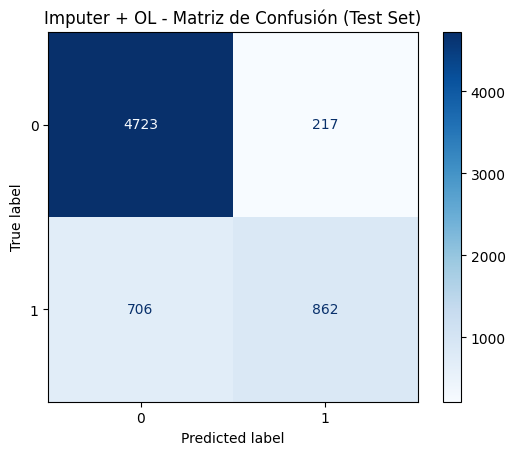

              precision    recall  f1-score   support

         0.0      0.870     0.956     0.911      4940
         1.0      0.799     0.550     0.651      1568

    accuracy                          0.858      6508
   macro avg      0.834     0.753     0.781      6508
weighted avg      0.853     0.858     0.848      6508



In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# El mejor modelo entrenado
best_model = joblib.load("results_out/prepro_imp_ol/best_model.joblib")
y_pred = best_model.predict(splits["X_test"])

# Matriz de confusión
cm = confusion_matrix(splits["y_test"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Imputer + OL - Matriz de Confusión (Test Set)")
plt.show()

# Reporte de clasificación
print(classification_report(splits["y_test"], y_pred, digits=3))


#### GRID SEARCH USANDO BALANCE

In [55]:
# Balancing Search -Agregamos class_weight y variantes de preprocesamiento

# MLflow
experiment.setup_mlflow_experiment(
    config["mlflow"]["tracking_uri"], 
    config["mlflow"]["experiment_name"]
)
param_grid = {
    "preprocessing__num__imputer__strategy": ["median"],
    "preprocessing__num__outlier__strategy": ["none", "clip"],
    "preprocessing__num__outlier__pmin": [0.01],
    "preprocessing__num__outlier__pmax": [0.99],
    "model__n_estimators": [200, 300],
    "model__max_depth": [10, 20],
    "model__class_weight": [None, "balanced", {0:1, 1:2}, {0:1, 1:3}],
}
experiment.run_gridsearch_experiment(
    pipeline=pipe,
    param_grid=param_grid,
    X_train=splits["X_train"],
    y_train=splits["y_train"],
    X_test=splits["X_test"],
    y_test=splits["y_test"],
    scoring="recall",  # o "f1"
    cv=5,
    out_dir="results_out/balancing_search"
)


[INFO] MLflow configurado: file:./mlruns, experimento: Mini_Proyecto_Adult_Income


2025/06/01 16:08:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/javs/anaconda3/envs/mlflow_env/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END model__class_weight=None, model__max_depth=10, model__n_estimators=200, preprocessing__num__imputer__strategy=median, preprocessing__num__outlier__pmax=0.99, preprocessing__num__outlier__pmin=0.01, preprocessing__num__outlier__strategy=none; total time=   6.8s
[CV] END model__class_weight=None, model__max_depth=10, model__n_estimators=200, preprocessing__num__imputer__strategy=median, preprocessing__num__outlier__pmax=0.99, preprocessing__num__outlier__pmin=0.01, preprocessing__num__outlier__strategy=none; total time=   8.3s
[CV] END model__class_weight=None, model__max_depth=10, model__n_estimators=200, preprocessing__num__imputer__strategy=median, preprocessing__num__outlier__pmax=0.99, preprocessing__num__outlier__pmin=0.01, preprocessing__num__outlier__strategy=none; total time=   9.3s
[CV] END model__class_weight=None, model__max_depth=10, model__n_estimators=200, preprocessing__num__imputer__strategy=median, p

2025/06/01 16:13:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/javs/anaconda3/envs/mlflow_env/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/01 16:13:41 INFO mlflow.sklearn.utils: Logging the 5 best runs, 27 runs will be omitted.


[INFO] Mejor score (cv): 0.860309603601549
[INFO] Mejores hiperparámetros: {'model__class_weight': None, 'model__max_depth': 10, 'model__n_estimators': 200, 'preprocessing__num__imputer__strategy': 'median', 'preprocessing__num__outlier__pmax': 0.99, 'preprocessing__num__outlier__pmin': 0.01, 'preprocessing__num__outlier__strategy': 'none'}
[INFO] Experimento terminado y trackeado en MLflow.


Mejores hiperparámetros: {

    class_weight: None, 

    max_depth: 10, 

    n_estimators: 200, 

    num__imputer__strategy: 'median', 

    num__outlier__pmax: 0.99, 

    num__outlier__pmin: 0.01, 

    num__outlier__strategy: 'none'

    }


##### VISUALIZACIÓN DE RESULTADOS

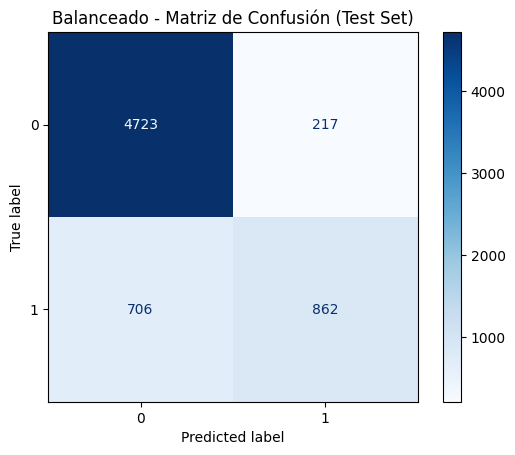

              precision    recall  f1-score   support

         0.0      0.870     0.956     0.911      4940
         1.0      0.799     0.550     0.651      1568

    accuracy                          0.858      6508
   macro avg      0.834     0.753     0.781      6508
weighted avg      0.853     0.858     0.848      6508



In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# El mejor modelo entrenado
best_model = joblib.load("results_out/balancing_search/best_model.joblib")
y_pred = best_model.predict(splits["X_test"])

# Matriz de confusión
cm = confusion_matrix(splits["y_test"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Balanceado - Matriz de Confusión (Test Set)")
plt.show()

# Reporte de clasificación
print(classification_report(splits["y_test"], y_pred, digits=3))

In [ ]:
## GRouping Search -Agregando agrupamiento de cat features a 'other'

# MLflow
experiment.setup_mlflow_experiment(
    config["mlflow"]["tracking_uri"], 
    config["mlflow"]["experiment_name"]
)

# 1. Define un grid específico para min_freq en variables críticas
param_grid = {
    # Solo exploramos agrupamiento para evitar combinatoria excesiva
    "preprocessing__cat_native.country__grouper__min_freq": [1, 50, 200, 500, 1000],
    "preprocessing__cat_occupation__grouper__min_freq": [1, 50, 200, 1000, 2000],
    "preprocessing__cat_workclass__grouper__min_freq": [1, 100, 1000, 3000],
    # Fijamos hiperparámetros conocidos
    "model__n_estimators": [300],
    "model__max_depth": [10],
    "model__class_weight": ["balanced"],
    # Outlier y demás fijos (ajusta si quieres testear también)
    "preprocessing__num__outlier__strategy": ["none"],
}


# 3. Construye el pipeline (usa features_dict según tu features_config.json)
pipe = pipeline.build_pipeline(config, features_dict)

# 4. Corre el experimento 
experiment.run_gridsearch_experiment(
    pipeline=pipe,
    param_grid=param_grid,
    X_train=splits["X_train"],
    y_train=splits["y_train"],
    X_test=splits["X_test"],
    y_test=splits["y_test"],
    scoring="recall",    # O "f1"
    cv=5,
    out_dir="results_out/grouping_search"
)

[INFO] MLflow configurado: file:./mlruns, experimento: Mini_Proyecto_Adult_Income
[INFO] ColumnTransformer construido con 8 transformadores.
[INFO] Pipeline completo construido: RandomForestClassifier


2025/06/01 10:54:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/javs/anaconda3/envs/mlflow_env/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=300, preprocessing__cat_native.country__grouper__min_freq=1, preprocessing__cat_occupation__grouper__min_freq=1, preprocessing__cat_workclass__grouper__min_freq=1, preprocessing__num__outlier__strategy=none; total time=  19.8s
[CV] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=300, preprocessing__cat_native.country__grouper__min_freq=1, preprocessing__cat_occupation__grouper__min_freq=1, preprocessing__cat_workclass__grouper__min_freq=100, preprocessing__num__outlier__strategy=none; total time=  20.2s
[CV] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=300, preprocessing__cat_native.country__grouper__min_freq=1, preprocessing__cat_occupation__grouper__min_freq=1, preprocessing__cat_workclass__grouper__min_freq=100, preprocessing__num__outlier__strategy=none; total time=  22.6s
[CV] END mod

2025/06/01 11:11:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/javs/anaconda3/envs/mlflow_env/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/01 11:11:53 INFO mlflow.sklearn.utils: Logging the 5 best runs, 95 runs will be omitted.


[INFO] Mejor score (cv): 0.8079450408768718
[INFO] Mejores hiperparámetros: {'model__class_weight': 'balanced', 'model__max_depth': 10, 'model__n_estimators': 300, 'preprocessing__cat_native.country__grouper__min_freq': 500, 'preprocessing__cat_occupation__grouper__min_freq': 200, 'preprocessing__cat_workclass__grouper__min_freq': 3000, 'preprocessing__num__outlier__strategy': 'none'}
[INFO] Experimento terminado y trackeado en MLflow.


[INFO] Mejores hiperparámetros: 

    class_weight: 'balanced',

    max_depth: 10, 

    n_estimators: 300, 

    native.country__grouper__min_freq: 500, 

    occupation__grouper__min_freq: 200, 

    workclass__grouper__min_freq: 3000, 

    num__outlier__strategy: 'none'


##### VISUALIZACIÓN DE RESULTADOS

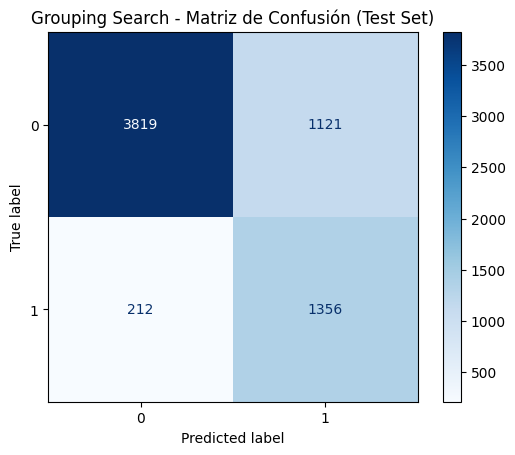

              precision    recall  f1-score   support

         0.0      0.947     0.773     0.851      4940
         1.0      0.547     0.865     0.670      1568

    accuracy                          0.795      6508
   macro avg      0.747     0.819     0.761      6508
weighted avg      0.851     0.795     0.808      6508



In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# El mejor modelo entrenado
best_model = joblib.load("results_out/grouping_search/best_model.joblib")
y_pred = best_model.predict(splits["X_test"])

# Matriz de confusión
cm = confusion_matrix(splits["y_test"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Grouping Search - Matriz de Confusión (Test Set)")
plt.show()

# Reporte de clasificación
print(classification_report(splits["y_test"], y_pred, digits=3))

#### COMBINANDO RESULTADOS ANTERIORES

In [30]:
## Explorando combinaciones de best_params obtenidos

# MLflow
experiment.setup_mlflow_experiment(
    config["mlflow"]["tracking_uri"], 
    config["mlflow"]["experiment_name"]
)

param_grid = {
    # Imputación numérica
    "preprocessing__num__imputer__strategy": ["median"],

    # Outlier handling (incluir "clip" para testear interacción)
    "preprocessing__num__outlier__strategy": ["none", "clip"],
    "preprocessing__num__outlier__pmin": [0.01],  # solo usado si "clip"
    "preprocessing__num__outlier__pmax": [0.98, 0.99],  # solo usado si "clip"

    # Imputación categórica
    "preprocessing__cat_workclass__imputer__strategy": ["most_frequent"],
    "preprocessing__cat_occupation__imputer__strategy": ["most_frequent"],
    "preprocessing__cat_native.country__imputer__strategy": ["most_frequent"],

    # Agrupamiento de categorías poco frecuentes
    "preprocessing__cat_native.country__grouper__min_freq": [500, 1000],
    "preprocessing__cat_occupation__grouper__min_freq": [200, 1000],
    "preprocessing__cat_workclass__grouper__min_freq": [1000, 3000],

    # RandomForest hiperparámetros
    "model__n_estimators": [200, 300],
    "model__max_depth": [10, 20],
    "model__class_weight": [None, "balanced", {0:1, 1:2}],
}

experiment.run_gridsearch_experiment(
    pipeline=pipe,
    param_grid=param_grid,
    X_train=splits["X_train"],
    y_train=splits["y_train"],
    X_test=splits["X_test"],
    y_test=splits["y_test"],
    scoring="recall",  # o "f1"
    cv=5,
    out_dir="results_out/comb_BestParams_search"
)


[INFO] MLflow configurado: file:./mlruns, experimento: Mini_Proyecto_Adult_Income


2025/06/01 12:16:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/javs/anaconda3/envs/mlflow_env/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] END model__class_weight=None, model__max_depth=10, model__n_estimators=200, preprocessing__cat_native.country__grouper__min_freq=500, preprocessing__cat_native.country__imputer__strategy=most_frequent, preprocessing__cat_occupation__grouper__min_freq=200, preprocessing__cat_occupation__imputer__strategy=most_frequent, preprocessing__cat_workclass__grouper__min_freq=1000, preprocessing__cat_workclass__imputer__strategy=most_frequent, preprocessing__num__imputer__strategy=median, preprocessing__num__outlier__pmax=0.98, preprocessing__num__outlier__pmin=0.01, preprocessing__num__outlier__strategy=none; total time=   9.5s
[CV] END model__class_weight=None, model__max_depth=10, model__n_estimators=200, preprocessing__cat_native.country__grouper__min_freq=500, preprocessing__cat_native.country__imputer__strategy=most_frequent, preprocessing__cat_occupation__grouper__min_freq=200, preprocessing__cat_occupation__imputer__stra

2025/06/01 13:11:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/javs/anaconda3/envs/mlflow_env/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/01 13:12:03 INFO mlflow.sklearn.utils: Logging the 5 best runs, 379 runs will be omitted.


[INFO] Mejor score (cv): 0.8625763076152063
[INFO] Mejores hiperparámetros: {'model__class_weight': None, 'model__max_depth': 20, 'model__n_estimators': 300, 'preprocessing__cat_native.country__grouper__min_freq': 500, 'preprocessing__cat_native.country__imputer__strategy': 'most_frequent', 'preprocessing__cat_occupation__grouper__min_freq': 200, 'preprocessing__cat_occupation__imputer__strategy': 'most_frequent', 'preprocessing__cat_workclass__grouper__min_freq': 1000, 'preprocessing__cat_workclass__imputer__strategy': 'most_frequent', 'preprocessing__num__imputer__strategy': 'median', 'preprocessing__num__outlier__pmax': 0.99, 'preprocessing__num__outlier__pmin': 0.01, 'preprocessing__num__outlier__strategy': 'clip'}
[INFO] Experimento terminado y trackeado en MLflow.


Mejores hiperparámetros: 

class_weight: None, 

max_depth: 20, 

n_estimators: 300, 

native.country__grouper__min_freq: 500, 

native.country__imputer__strategy: 'most_frequent',

occupation__grouper__min_freq: 200, 

occupation__imputer__strategy: 'most_frequent', 

workclass__grouper__min_freq: 1000, 

workclass__imputer__strategy: 'most_frequent', 

num__imputer__strategy: 'median',

num__outlier__pmax: 0.99, 

num__outlier__pmin: 0.01, 

num__outlier__strategy: 'clip'

##### VISUALIZACIÓN DE RESULTADOS

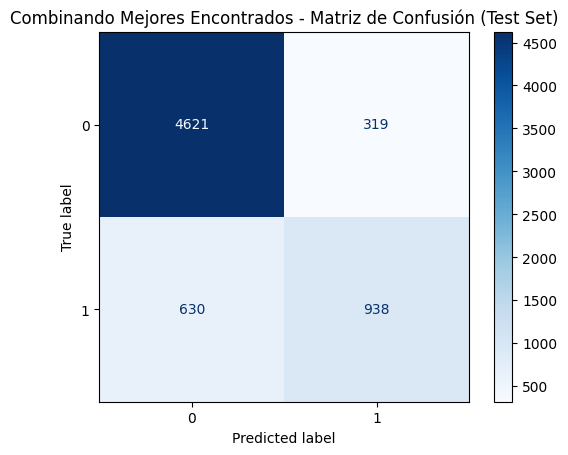

              precision    recall  f1-score   support

         0.0      0.880     0.935     0.907      4940
         1.0      0.746     0.598     0.664      1568

    accuracy                          0.854      6508
   macro avg      0.813     0.767     0.785      6508
weighted avg      0.848     0.854     0.848      6508



In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# El mejor modelo entrenado
best_model = joblib.load("results_out/comb_BestParams_search/best_model.joblib")
y_pred = best_model.predict(splits["X_test"])

# Matriz de confusión
cm = confusion_matrix(splits["y_test"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Combinando Mejores Encontrados - Matriz de Confusión (Test Set)")
plt.show()

# Reporte de clasificación
print(classification_report(splits["y_test"], y_pred, digits=3))

#### ÚLTIMOS (más) EXPERIMENTOS CON RF

In [ ]:
## Grid de Recapitulacion - Combinando lo aprendido

# MLflow
experiment.setup_mlflow_experiment(
    config["mlflow"]["tracking_uri"], 
    config["mlflow"]["experiment_name"]
)

param_grid = {
    # Imputación numérica
    "preprocessing__num__imputer__strategy": ["median"],

    # Outlier handling (incluye clip para control)
    "preprocessing__num__outlier__strategy": ["none", "clip"],
    "preprocessing__num__outlier__pmin": [0.01],  # si clip
    "preprocessing__num__outlier__pmax": [0.99],  # si clip

    # Imputación categórica
    "preprocessing__cat_workclass__imputer__strategy": ["most_frequent"],
    "preprocessing__cat_occupation__imputer__strategy": ["most_frequent"],
    "preprocessing__cat_native.country__imputer__strategy": ["most_frequent"],

    # Agrupamiento de categorías poco frecuentes (mejores de grids previos)
    "preprocessing__cat_native.country__grouper__min_freq": [500, 1000],
    "preprocessing__cat_occupation__grouper__min_freq": [200, 1000],
    "preprocessing__cat_workclass__grouper__min_freq": [1000, 3000],

    # RandomForest hiperparámetros
    "model__n_estimators": [200, 300],
    "model__max_depth": [10, 20],
    "model__class_weight": [None, "balanced", {0:1, 1:2}],
    # Si tienes implementado min_samples_leaf, puedes agregar: 
    "model__min_samples_leaf": [1, 5],
}


experiment.run_gridsearch_experiment(
    pipeline=pipe,
    param_grid=param_grid,
    X_train=splits["X_train"],
    y_train=splits["y_train"],
    X_test=splits["X_test"],
    y_test=splits["y_test"],
    scoring="recall",  # o "f1"
    cv=5,
    out_dir="results_out/mas_exps_rf" ## corregido nombre
)


[INFO] MLflow configurado: file:./mlruns, experimento: Mini_Proyecto_Adult_Income


2025/06/01 13:36:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/javs/anaconda3/envs/mlflow_env/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] END model__class_weight=None, model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=200, preprocessing__cat_native.country__grouper__min_freq=500, preprocessing__cat_native.country__imputer__strategy=most_frequent, preprocessing__cat_occupation__grouper__min_freq=200, preprocessing__cat_occupation__imputer__strategy=most_frequent, preprocessing__cat_workclass__grouper__min_freq=1000, preprocessing__cat_workclass__imputer__strategy=most_frequent, preprocessing__num__imputer__strategy=median, preprocessing__num__outlier__pmax=0.99, preprocessing__num__outlier__pmin=0.01, preprocessing__num__outlier__strategy=none; total time=   9.8s
[CV] END model__class_weight=None, model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=200, preprocessing__cat_native.country__grouper__min_freq=500, preprocessing__cat_native.country__imputer__strategy=most_frequent, preprocessing__cat_occupation__grouper__min_

2025/06/01 14:30:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/javs/anaconda3/envs/mlflow_env/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/01 14:30:37 INFO mlflow.sklearn.utils: Logging the 5 best runs, 379 runs will be omitted.


[INFO] Mejor score (cv): 0.863459947751117
[INFO] Mejores hiperparámetros: {'model__class_weight': None, 'model__max_depth': 20, 'model__min_samples_leaf': 5, 'model__n_estimators': 200, 'preprocessing__cat_native.country__grouper__min_freq': 500, 'preprocessing__cat_native.country__imputer__strategy': 'most_frequent', 'preprocessing__cat_occupation__grouper__min_freq': 1000, 'preprocessing__cat_occupation__imputer__strategy': 'most_frequent', 'preprocessing__cat_workclass__grouper__min_freq': 1000, 'preprocessing__cat_workclass__imputer__strategy': 'most_frequent', 'preprocessing__num__imputer__strategy': 'median', 'preprocessing__num__outlier__pmax': 0.99, 'preprocessing__num__outlier__pmin': 0.01, 'preprocessing__num__outlier__strategy': 'none'}
[INFO] Experimento terminado y trackeado en MLflow.


Mejores hiperparámetros:
'model__class_weight': None, 

'model__max_depth': 20, 

'model__min_samples_leaf': 5, 

'model__n_estimators': 200, 

native.country__grouper__min_freq': 500, 

native.country__imputer__strategy': 'most_frequent', 

occupation__grouper__min_freq': 1000, 

occupation__imputer__strategy': 'most_frequent', 

workclass__grouper__min_freq': 1000, 

workclass__imputer__strategy': 'most_frequent', 

num__imputer__strategy': 'median', 

num__outlier__pmax': 0.99, 

num__outlier__pmin': 0.01, 

num__outlier__strategy': 'none'


##### VISUALIZACIÓN DE RESULTADOS

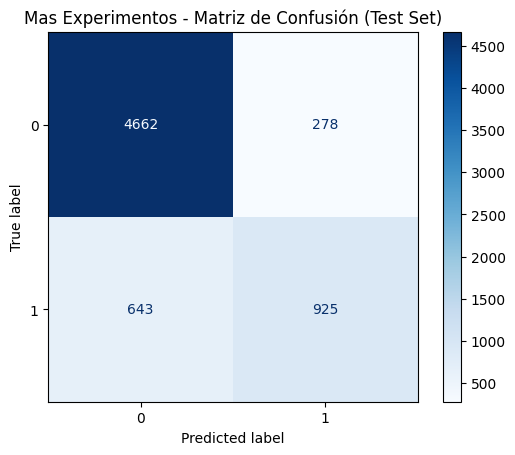

              precision    recall  f1-score   support

         0.0      0.879     0.944     0.910      4940
         1.0      0.769     0.590     0.668      1568

    accuracy                          0.858      6508
   macro avg      0.824     0.767     0.789      6508
weighted avg      0.852     0.858     0.852      6508



In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# El mejor modelo entrenado
best_model = joblib.load("results_out/mas_exps_rf/best_model.joblib")
y_pred = best_model.predict(splits["X_test"])

# Matriz de confusión
cm = confusion_matrix(splits["y_test"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Mas Experimentos - Matriz de Confusión (Test Set)")
plt.show()

# Reporte de clasificación
print(classification_report(splits["y_test"], y_pred, digits=3))

#### RESULTADOS CON RF

In [38]:
# Definir directorio donde están los resultados
base_dir = "results_out"
experiment_names = [
    "prepro_imp_ol",
    "balancing_search",
    "grouping_search",
    "comb_BestParams_search",
    "mas_exps_rf"
]

summary = []

for exp in experiment_names:
    exp_path = os.path.join(base_dir, exp)
    # Cargar mejores parámetros
    with open(os.path.join(exp_path, "best_params.json")) as f:
        best_params = json.load(f)
    # Cargar cv_results y tomar el mejor
    cv_results = pd.read_csv(os.path.join(exp_path, "cv_results.csv"))
    # Usualmente best_index_ está en los atributos, si no, tomamos el mejor según "mean_test_score"
    if "rank_test_score" in cv_results.columns:
        idx = cv_results["rank_test_score"].idxmin()
    else:
        idx = cv_results["mean_test_score"].idxmax()
    best_row = cv_results.iloc[idx]
    
    # Puedes agregar aquí las métricas que te interesen (f1, recall, etc)
    # O ajusta los nombres si cambiaste scoring
    summary.append({
        "experimento": exp,
        "accuracy (cv)": best_row.get("mean_test_score", None),
        "std (cv)": best_row.get("std_test_score", None),
        "params": best_params,
        # Si tienes más scorers, agrega aquí
        "mean_fit_time": best_row.get("mean_fit_time", None)
    })
    
# Crear dataframe resumen
summary_df = pd.DataFrame(summary)

# Mostrar tabla resumen ordenada por accuracy
display(summary_df.sort_values(by="accuracy (cv)", ascending=False))

,experimento,accuracy (cv),std (cv),params,mean_fit_time
4,mas_exps_rf,0.863460,0.003112,"{'model__class_weight': None, 'model__max_dept...",9.314338
3,comb_BestParams_search,0.862576,0.003698,"{'model__class_weight': None, 'model__max_dept...",14.611264
0,prepro_imp_ol,0.860310,0.002215,"{'model__class_weight': None, 'model__max_dept...",9.353398
1,balancing_search,0.860310,0.002215,"{'model__class_weight': None, 'model__max_dept...",8.232343
2,grouping_search,0.807945,0.002340,"{'model__class_weight': 'balanced', 'model__ma...",11.815081


/tmp/ipykernel_6938/2720286936.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_summary["experimento"], rotation=15)
/tmp/ipykernel_6938/2720286936.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_summary["experimento"], rotation=15)
/tmp/ipykernel_6938/2720286936.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_summary["experimento"], rotation=15)
/tmp/ipykernel_6938/2720286936.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_summary["experimento"], rotation=15)


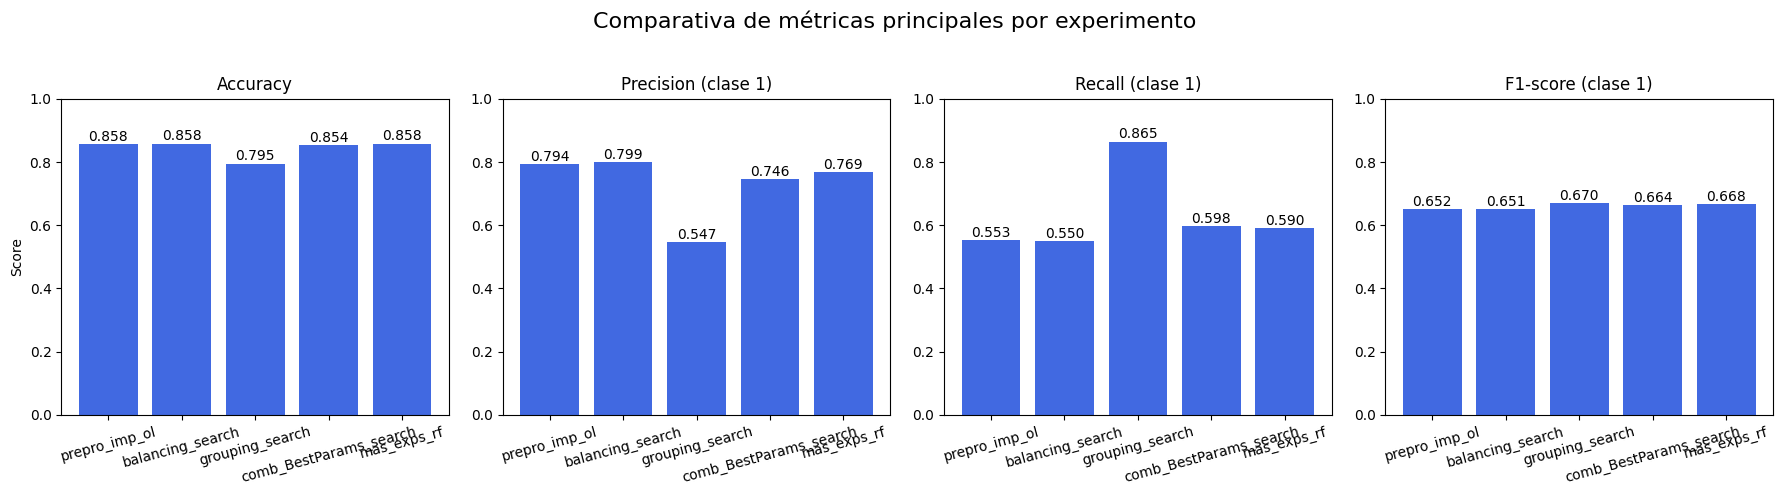

In [63]:
# Visualización comparativa de accuracy, recall, precision y f1-score
metrics = ["accuracy", "precision_1", "recall_1", "f1_1"]
titles = ["Accuracy", "Precision (clase 1)", "Recall (clase 1)", "F1-score (clase 1)"]

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i]
    ax.bar(df_summary["experimento"], df_summary[metric], color="royalblue")
    ax.set_ylim(0, 1)
    ax.set_title(title)
    for idx, val in enumerate(df_summary[metric]):
        ax.text(idx, val + 0.01, f"{val:.3f}", ha="center")
    if i == 0:
        ax.set_ylabel("Score")
    ax.set_xticklabels(df_summary["experimento"], rotation=15)
plt.suptitle("Comparativa de métricas principales por experimento", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

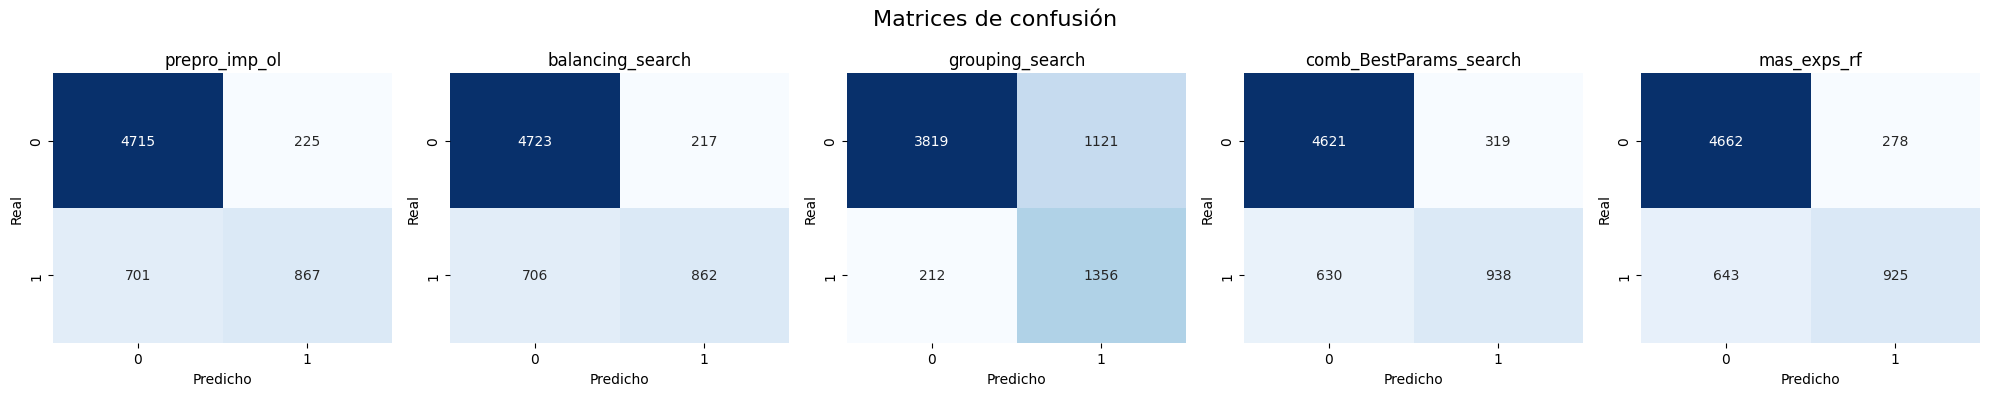

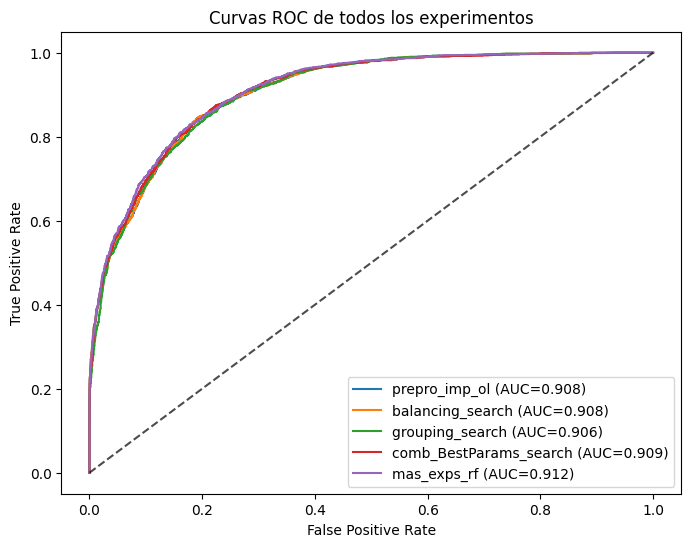

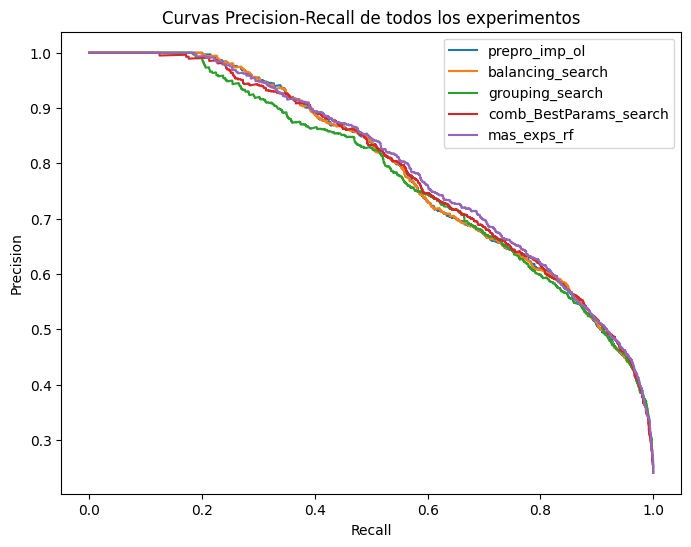

In [64]:

# Para guardar resultados de cada experimento
results = {}

# Loop y almacenamos resultados de interés
for exp in experiment_names:
    exp_path = os.path.join(base_dir, exp)
    model = joblib.load(os.path.join(exp_path, "best_model.joblib"))
    with open(os.path.join(exp_path, "best_params.json")) as f:
        best_params = json.load(f)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[exp] = {
        "cm": cm,
        "roc": (fpr, tpr, roc_auc),
        "pr": (recall, precision),
        "report": report
    }

# Matrices de confusión (en panel)
n = len(experiment_names)
fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
for i, exp in enumerate(experiment_names):
    ax = axes[i]
    cm = results[exp]["cm"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(exp)
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")
fig.suptitle("Matrices de confusión", fontsize=16)
plt.tight_layout()
plt.show()

# Curvas ROC (juntas)
plt.figure(figsize=(8,6))
for exp in experiment_names:
    fpr, tpr, roc_auc = results[exp]["roc"]
    plt.plot(fpr, tpr, label=f"{exp} (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--', alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC de todos los experimentos")
plt.legend()
plt.show()

# Curvas Precision-Recall (juntas)
plt.figure(figsize=(8,6))
for exp in experiment_names:
    recall, precision = results[exp]["pr"]
    plt.plot(recall, precision, label=exp)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precision-Recall de todos los experimentos")
plt.legend()
plt.show()

In [68]:
X_train, y_train = splits["X_train"], splits["y_train"]
X_train

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
25267,21,nan,10,Never-married,nan,Own-child,White,Male,0,0,20,United-States
3349,41,Private,11,Married-civ-spouse,Sales,Husband,White,Male,4386,0,60,United-States
4584,24,Private,9,Never-married,Handlers-cleaners,Unmarried,Black,Female,0,0,40,United-States
7003,59,Private,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,18,United-States
882,35,Private,9,Married-civ-spouse,Sales,Husband,Asian-Pac-Islander,Male,0,1887,50,Iran
...,...,...,...,...,...,...,...,...,...,...,...,...
31107,17,Local-gov,5,Never-married,Other-service,Own-child,White,Male,0,0,45,United-States
10982,42,Private,5,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,Mexico
22425,55,Private,10,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States
8200,22,Private,9,Never-married,Other-service,Own-child,White,Male,0,0,40,United-States


,accuracy,precision_1,recall_1,f1_1,roc_auc
experimento,,,,,
prepro_imp_ol,0.858,0.794,0.553,0.652,0.908
balancing_search,0.858,0.799,0.550,0.651,0.908
grouping_search,0.795,0.547,0.865,0.670,0.906
comb_BestParams_search,0.854,0.746,0.598,0.664,0.909
mas_exps_rf,0.858,0.769,0.590,0.668,0.912


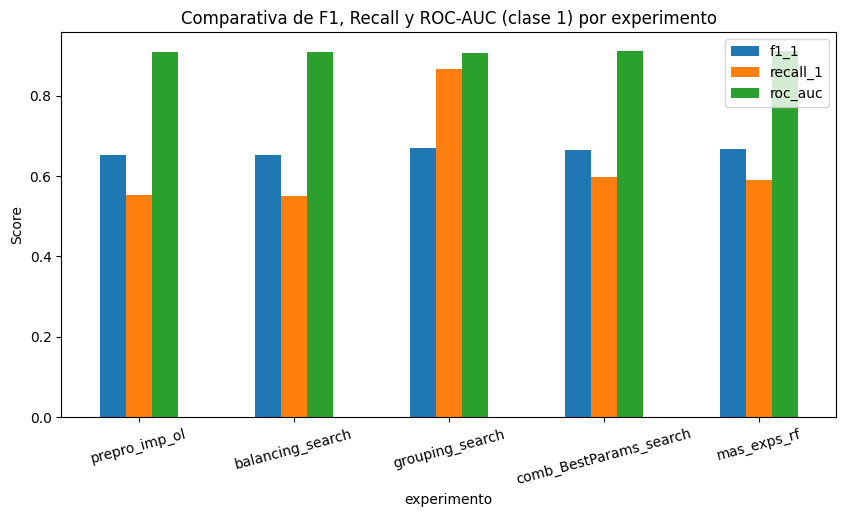

In [ ]:
# Tabla resumen de métricas principales

summary = []

for exp in experiment_names:
    r = results[exp]["report"]
    roc_auc = results[exp]["roc"][2]
    
    # Detectar la key que corresponde a la clase 1
    cls_keys = [k for k in r.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
    pos_label = None
    for k in ['1', 1, 1.0, '>50K']:
        if k in cls_keys:
            pos_label = k
            break
    if pos_label is None:
        # Si no encuentra, elige el más alto (supone binario 0/1)
        try:
            pos_label = max(cls_keys, key=lambda x: float(x))
        except:
            pos_label = cls_keys[-1]  # fallback a último
    
    summary.append({
        "experimento": exp,
        "accuracy": r["accuracy"],
        "precision_1": r[pos_label]["precision"],
        "recall_1": r[pos_label]["recall"],
        "f1_1": r[pos_label]["f1-score"],
        "roc_auc": roc_auc
    })
df_summary = pd.DataFrame(summary)
display(df_summary.set_index("experimento").round(3))

# (Opcional: puedes graficar cada métrica comparativa con barras)
df_summary.set_index("experimento")[["f1_1", "recall_1", "roc_auc"]].plot.bar(figsize=(10,5), rot=15)
plt.title("Comparativa de F1, Recall y ROC-AUC (clase 1) por experimento")
plt.ylabel("Score")
plt.show()
